# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Предоставленны следующие архивные данные:

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
Price — цена (евро)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from time import time
warnings.filterwarnings('ignore')

## Подготовка данных

Загрузим и рассмотрим данные:

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv("C:/Users/chern/autos.csv")
    
display(df.head(10))
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Проверим данные на наличие дубликатов и удалим их при необходимости:

In [3]:
df.duplicated().sum()

4

In [4]:
df = df.drop_duplicates()

Приведем столбцы Gearbox и Repaired к булевому виду:

In [5]:
display(df['Gearbox'].astype(bool))
df['Repaired'].astype(bool)

0         True
1         True
2         True
3         True
4         True
          ... 
354364    True
354365    True
354366    True
354367    True
354368    True
Name: Gearbox, Length: 354365, dtype: bool

0         True
1         True
2         True
3         True
4         True
          ... 
354364    True
354365    True
354366    True
354367    True
354368    True
Name: Repaired, Length: 354365, dtype: bool

Оставим в датафрейме только те столбцы, которые важны, для определения стоимости автомобиля:

In [6]:
df_sub = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']].copy()

In [7]:
df_sub = df_sub.reset_index(drop=True)
df_sub.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проверим данные на наличие пропусков:

In [8]:
df_sub.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Посмотрим какая доля данных пропущена:

In [9]:
display(df_sub['VehicleType'].isna().sum() / len(df_sub['VehicleType'])*100)
display(df_sub['Gearbox'].isna().sum() / len(df_sub['VehicleType'])*100)
display(df_sub['Model'].isna().sum() / len(df_sub['Model'])*100)
display(df_sub['FuelType'].isna().sum() / len(df_sub['FuelType'])*100)
display(df_sub['Repaired'].isna().sum() / len(df_sub['FuelType'])*100)

10.57948725184485

5.596771690206426

5.560650741467131

9.282801631086592

20.07929677027923

Пропущена небольшая доля от всех данных по каждому столбцу, кроме столбца Repaired, но тем не менее суммарная доля пропсуков слишком высокая. Используем заглушки в виде новых значений категорий по всем столбцам с пропусками

In [10]:
columns_to_replace = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

for column in columns_to_replace:
    df_sub[column] = df_sub[column].fillna(value='unknown')

df_sub.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Рассмотрим численные признаки на наличие аномалий:

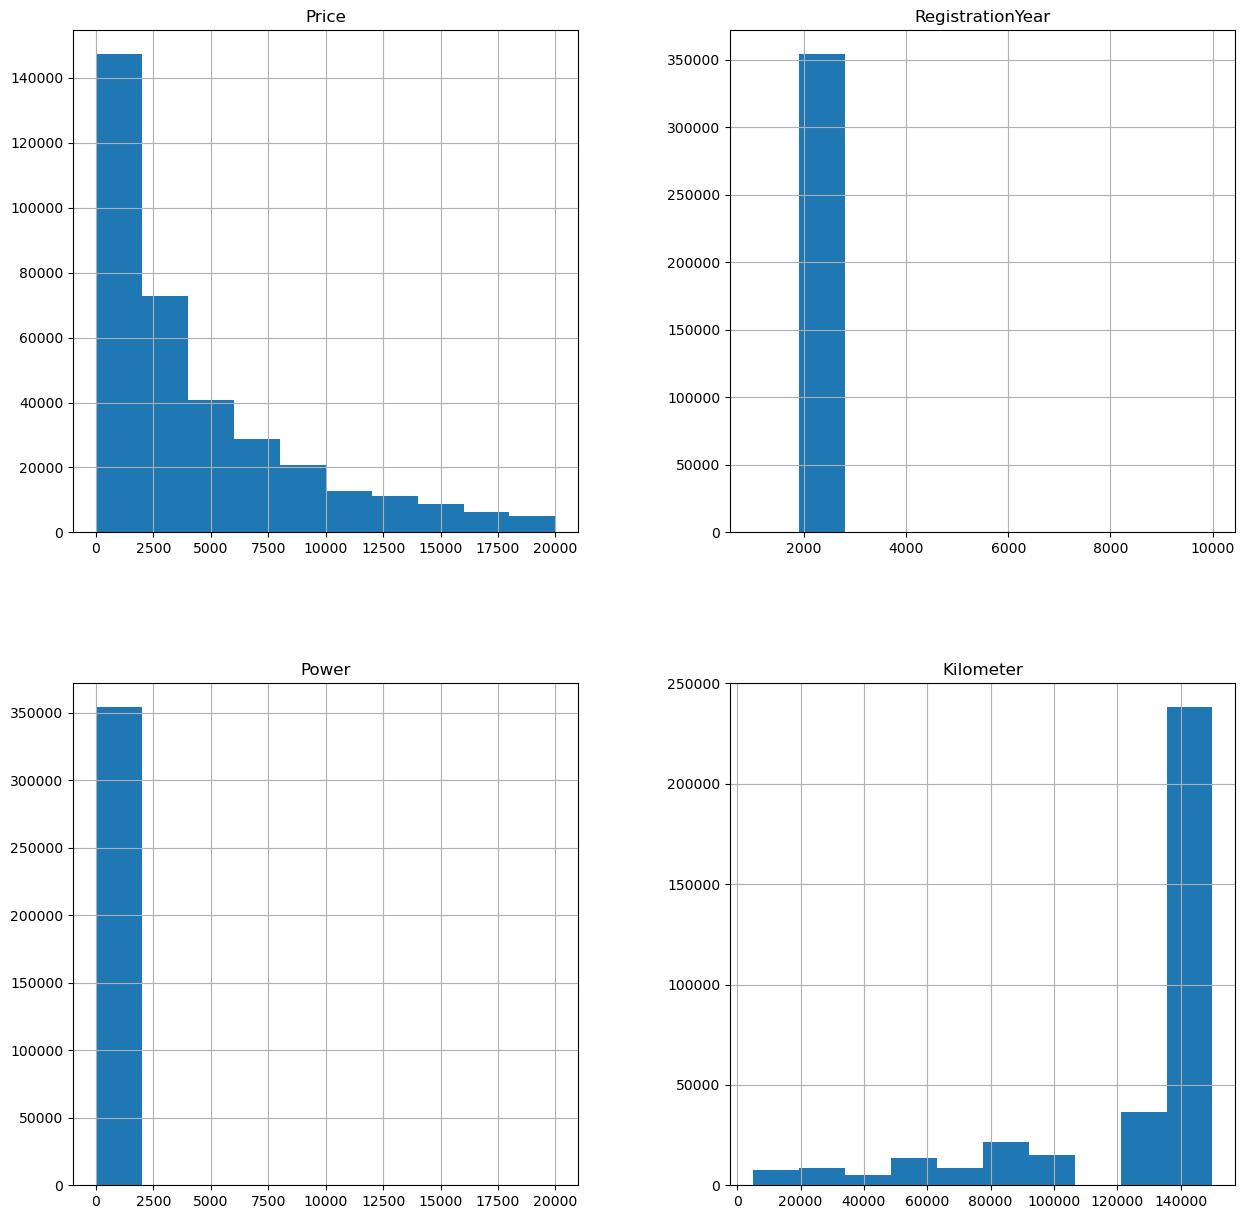

In [11]:
df_sub.hist(figsize=(15, 15));

In [12]:
df_sub['Price'].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000], dtype=int64)

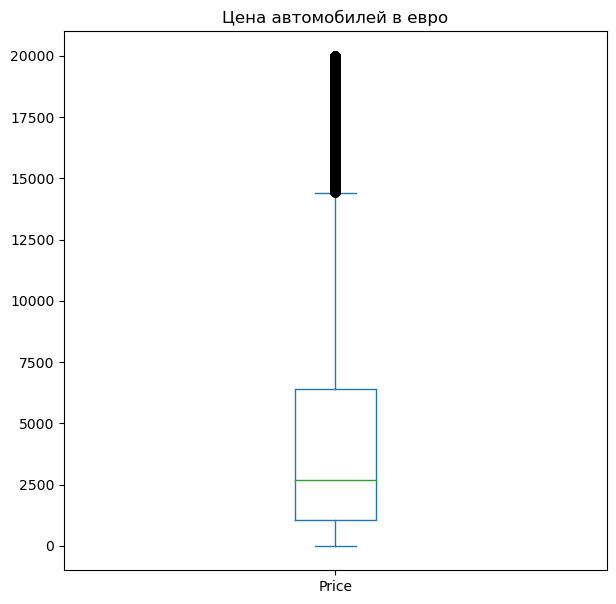

In [13]:
df_sub['Price'].plot(y='age', kind='box', title='Цена автомобилей в евро', figsize=(7, 7)); 

Видим нулевую цену и другие аномально низкие цены, например, 1-2 евро. Удалим автомобили с ценой ниже 15 евро: 

In [14]:
df_sub = df_sub.query('Price > 500')

In [15]:
df_sub['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1234, 1400, 1500, 1600, 1800, 1910, 1923, 1925,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2066, 2290, 2500, 2800, 2900, 3000, 3200,
       3700, 4000, 4100, 4500, 5000, 5300, 5555, 5911, 6000, 7000, 7100,
       7800, 8500, 8888, 9000, 9450, 9999], dtype=int64)

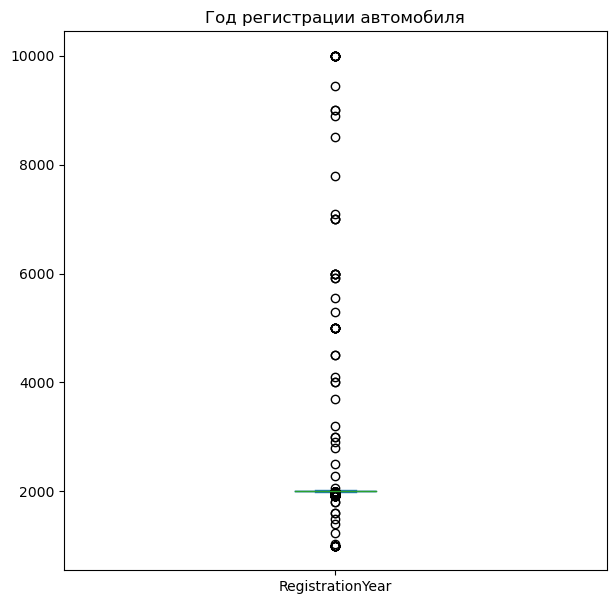

In [16]:
df_sub['RegistrationYear'].plot(y='age', kind='box', title='Год регистрации автомобиля', figsize=(7, 7)); 

Также видим странные значения года. Удалим аномальные значения года и совсем старые автомобили, старше 50 лет:

In [17]:
df_sub = df_sub.query('RegistrationYear >= 1970 & RegistrationYear < 2017')

In [18]:
df_sub['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    33,    34,    35,    36,
          37,    38,    39,    40,    41,    42,    43,    44,    45,
          46,    47,    48,    49,    50,    51,    52,    53,    54,
          55,    56,    57,    58,    59,    60,    61,    62,    63,
          64,    65,    66,    67,    68,    69,    70,    71,    72,
          73,    74,    75,    76,    77,    78,    79,    80,    81,
          82,    83,    84,    85,    86,    87,    88,    89,    90,
          91,    92,    93,    94,    95,    96,    97,    98,    99,
         100,   101,   102,   103,   104,   105,   106,   107,   108,
         109,   110,   111,   112,   113,   114,   115,   116,   117,
         118,   119,   120,   121,   122,   123,   124,   125,   126,
         127,   128,

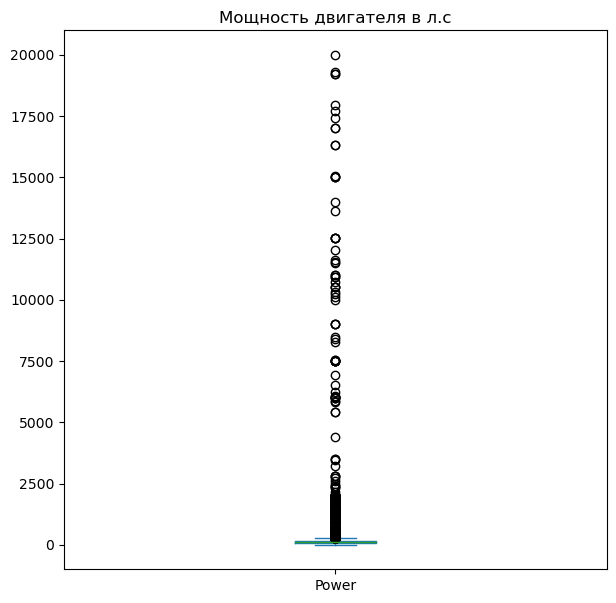

In [19]:
df_sub['Power'].plot(y='age', kind='box', title='Мощность двигателя в л.с', figsize=(7, 7)); 

Удалим мощность равную нулю и аномально высокую мощность:

In [20]:
df_sub = df_sub.query('Power >= 4 & Power < 2000')

Данные столбца Kilometer на гистограмме выглядят нормально.

In [21]:
df_sub.Kilometer.describe()

count    274467.000000
mean     127575.136537
std       36984.569540
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Рассмотрим категориальные данные:

In [22]:
display(df_sub.VehicleType.unique())
display(df_sub.Gearbox.unique())
display(df_sub.Model.unique())
display(df_sub.FuelType.unique())
display(df_sub.Brand.unique())
display(df_sub.Repaired.unique())

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'unknown', 'other'], dtype=object)

array(['manual', 'auto', 'unknown'], dtype=object)

array(['unknown', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'civic', 'transporter', 'punto', 'e_klasse', 'clio',
       'kadett', 'other', 'one', 'fortwo', '1er', 'b_klasse', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a1', 'focus', 'a4',
       'tt', 'astra', 'a6', 'jazz', 'polo', 'slk', '7er', 'combo', '80',
       '147', 'z_reihe', 'sorento', 'ibiza', 'mustang', 'eos', 'touran',
       'getz', 'insignia', 'ka', 'almera', 'megane', 'a3', 'lupo',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', 'corsa', '6er', 'modus', 'fox', 'matiz', 'beetle',
       'rio', 'touareg', 'logan', 'spider', 'omega', 'cuore', 's_max',
       'a2', 'galax

array(['gasoline', 'petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'subaru', 'volvo',
       'mitsubishi', 'alfa_romeo', 'kia', 'seat', 'suzuki', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'sonstige_autos',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'trabant', 'land_rover', 'lada'], dtype=object)

array(['yes', 'unknown', 'no'], dtype=object)

Еще раз проверим данные на наличие дубликатов и удалим их в случае необходимости:

In [23]:
df_sub.duplicated().sum()

36688

In [24]:
df_sub = df_sub.drop_duplicates()
df_sub.duplicated().sum()

0

**Вывод:**

Данные состоят из 16 столбцов и 354369 строк. В нескольких столбцах содержались пропуски, общая доля которых довольно высока, заменили пропуски отдельной категорией unknown. 
Удалили 4  дубликата из данных.
Подготовили данные к обучению, удалив неважные для обучения столбцы. Получили 9 столбцов с признаками и один с целевым признаком.
Обработали анамольные значения в числовых данных.

## Обучение моделей

Разделим данные на признаки и целевой признак:

In [25]:
features = df_sub.drop(['Price'], axis=1)
target = df_sub['Price']

Разделим данные на обучающую и тестовую выборки в соотношении 75:25

In [26]:
R_STATE = 12345

In [27]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=R_STATE)

display(features_train, features_test, target_train, target_test)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
164326,small,2010,manual,60,fabia,50000,petrol,skoda,no
135606,unknown,2016,manual,101,a4,150000,petrol,audi,no
198806,sedan,2003,manual,179,golf,150000,petrol,volkswagen,no
259323,small,1997,manual,75,civic,125000,petrol,honda,yes
26633,sedan,1998,manual,98,other,125000,petrol,chrysler,no
...,...,...,...,...,...,...,...,...,...
116973,small,2008,manual,75,unknown,60000,petrol,chevrolet,no
187470,sedan,1999,manual,116,focus,150000,petrol,ford,no
182985,sedan,2005,auto,231,5er,150000,gasoline,bmw,yes
105210,sedan,2008,auto,200,golf,150000,petrol,volkswagen,no


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
43157,sedan,2000,auto,224,s_klasse,150000,petrol,mercedes_benz,no
271088,wagon,2008,manual,87,logan,70000,petrol,dacia,no
321102,small,2010,manual,95,colt,90000,unknown,mitsubishi,no
225254,unknown,2000,manual,101,a3,150000,unknown,audi,unknown
289901,wagon,1998,auto,110,sharan,5000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...
130106,bus,2011,manual,105,c_max,60000,petrol,ford,no
87433,sedan,2006,manual,140,passat,150000,gasoline,volkswagen,no
162068,bus,2001,manual,116,sharan,150000,gasoline,volkswagen,no
168306,sedan,2006,manual,218,5er,150000,petrol,bmw,no


164326     5900
135606      750
198806     4500
259323     1400
26633      1250
          ...  
116973     2650
187470     1750
182985     6500
105210     8500
320656    10789
Name: Price, Length: 178334, dtype: int64

43157      3600
271088     4350
321102     6000
225254     1600
289901     1690
          ...  
130106    10350
87433      5800
162068     4350
168306     8150
259601     6999
Name: Price, Length: 59445, dtype: int64

Преобразуем категориальные признаки в численные техникой OrdinalEncoder():

In [28]:
columns_cat = ['VehicleType', 'Model', 'FuelType', 'Brand', 'Repaired', 'Gearbox']

In [29]:
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [30]:
encoder_oe.fit(features_train[columns_cat])
features_train_oe = features_train.copy()
features_train_oe[columns_cat] = pd.DataFrame(encoder_oe.transform(features_train[columns_cat]), 
                                              columns=features_train[columns_cat].columns,
                                              index=features_train_oe.index)
features_train_oe = features_train_oe.reset_index(drop=True)

In [31]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
encoder_ohe.fit(features_train[columns_cat])
features_train_ohe = features_train.copy()
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[columns_cat])                                    
features_train_ohe = features_train_ohe.drop(features_train[columns_cat], axis=1)
features_train_ohe = features_train_ohe.reset_index(drop=True)


In [32]:
pd.set_option('display.max_columns', None)
display(features_train_ohe)
features_train_oe

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes,Gearbox_manual,Gearbox_unknown
0,2010,60,50000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,5.0,2010,1.0,60,101.0,50000,6.0,31.0,0.0
1,7.0,2016,1.0,101,29.0,150000,6.0,1.0,0.0
2,4.0,2003,1.0,179,116.0,150000,6.0,38.0,0.0
3,5.0,1997,1.0,75,73.0,125000,6.0,11.0,2.0
4,4.0,1998,1.0,98,166.0,125000,6.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
178329,5.0,2008,1.0,75,226.0,60000,6.0,3.0,0.0
178330,4.0,1999,1.0,116,103.0,150000,6.0,10.0,0.0
178331,4.0,2005,0.0,231,15.0,150000,2.0,2.0,2.0
178332,4.0,2008,0.0,200,116.0,150000,6.0,38.0,0.0


Стандартизируем численные данные:

In [33]:
def scaled(data):
    numeric = data.columns
    scaler = StandardScaler()
    scaler.fit(data[numeric]) 
    return scaler.transform(data[numeric])


display(scaled(features_train_ohe))
scaled(features_train_oe)

array([[ 1.06943722, -1.01649733, -2.03214012, ..., -0.30284658,
         0.54788692, -0.13320248],
       [ 2.0336154 , -0.38029907,  0.6252799 , ..., -0.30284658,
         0.54788692, -0.13320248],
       [-0.05543734,  0.83002932,  0.6252799 , ..., -0.30284658,
         0.54788692, -0.13320248],
       ...,
       [ 0.26595539,  1.63691492,  0.6252799 , ...,  3.302002  ,
        -1.82519414, -0.13320248],
       [ 0.74804449,  1.15588697,  0.6252799 , ..., -0.30284658,
        -1.82519414, -0.13320248],
       [ 1.39082995, -0.78374187, -3.22797913, ..., -0.30284658,
         0.54788692, -0.13320248]])

array([[ 0.20260951,  1.06943722,  0.4467957 , ...,  0.65785178,
         0.7932585 , -0.49775554],
       [ 1.01517084,  2.0336154 ,  0.4467957 , ...,  0.65785178,
        -1.4473624 , -0.49775554],
       [-0.20367115, -0.05543734,  0.4467957 , ...,  0.65785178,
         1.31607004, -0.49775554],
       ...,
       [-0.20367115,  0.26595539, -1.83267401, ..., -1.43622194,
        -1.37267504,  2.74308917],
       [-0.20367115,  0.74804449, -1.83267401, ...,  0.65785178,
         1.31607004, -0.49775554],
       [ 0.20260951,  1.39082995,  0.4467957 , ..., -1.43622194,
         1.31607004, -0.49775554]])

Обучим данные моделью - **Дерево Решений** с использованием кодировщика OneHotEncoder:

In [34]:
%%time

parametrs = {'max_depth': range (1, 10)}
model = DecisionTreeRegressor(random_state=R_STATE)

grid_search = GridSearchCV(model, param_grid=parametrs, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train_ohe, target_train)

best_parametrs = pd.Series(grid_search.best_params_)[0]
best_score_rough_DT = -1 * grid_search.best_score_

print("Лучшее значение глубины:", best_parametrs)
print("Лучшая оценка кросс-валидации:", best_score_rough_DT)

Лучшее значение глубины: 9
Лучшая оценка кросс-валидации: 2066.672678111925
CPU times: total: 1min 13s
Wall time: 1min 13s


In [35]:
%%time

start = time()
model = DecisionTreeRegressor(random_state=R_STATE, max_depth=9)
model.fit(features_train_ohe, target_train) 
end = time()
model_time_DT = (end-start)/60

start = time()
model.predict(features_train_ohe)
end = time()
model_time_DTP = (end-start)/60

print("Время обучения в минутах:", model_time_DT)
print("Время предсказания в минутах:", model_time_DTP)

Время обучения в минутах: 0.04390360116958618
Время предсказания в минутах: 0.004963155587514242
CPU times: total: 2.92 s
Wall time: 2.93 s


Обучим данные моделью - **Линейная регрессия** с использованием кодировщика OneHotEncoder:

In [36]:
%%time

start = time()
  
model = LinearRegression()
model.fit(features_train_ohe, target_train)

end = time()

model_time_LR = (end-start)/60

print("Время обучения в минутах:", model_time_LR)

Время обучения в минутах: 0.04793680111567179
CPU times: total: 9.39 s
Wall time: 2.88 s


In [37]:
%%time

start = time()
prediction_LR = model.predict(features_train_ohe)
end = time()
model_time_LRP = (end-start)/60

best_score_rough_LR = mean_squared_error(target_train, prediction_LR) ** 0.5

print("Лучшая оценка кросс-валидации:", best_score_rough_LR)
print("Время предсказания в минутах:", model_time_LRP)

Лучшая оценка кросс-валидации: 2659.4639682893144
Время предсказания в минутах: 0.004128436247507731
CPU times: total: 578 ms
Wall time: 251 ms


Обучим данные моделью - **CatBoost** с использованием собственного кодировщика cat_features: 

In [38]:
%%time


parametrs = {'depth': range (1, 10),
             'n_estimators': range(1, 10)
}
cat_features = ['VehicleType', 'Model', 'FuelType', 'Brand', 'Repaired', 'Gearbox']

model = CatBoostRegressor(random_state=R_STATE, learning_rate=0.5, 
                          cat_features = cat_features)

grid_search = GridSearchCV(model, param_grid=parametrs, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train, target_train, verbose=False)

best_parametrs = grid_search.best_params_
best_score_rough_CB = -1 * grid_search.best_score_

print("Лучшее значение параметров:", best_parametrs)
print("Лучшая оценка кросс-валидации:", best_score_rough_CB)

Лучшее значение параметров: {'depth': 9, 'n_estimators': 9}
Лучшая оценка кросс-валидации: 1818.0848410848848
CPU times: total: 13min 2s
Wall time: 5min 18s


In [39]:
%%time

start = time()
model = CatBoostRegressor(random_state=R_STATE, depth=9, n_estimators=9, learning_rate=0.5, 
                          cat_features = cat_features)
model.fit(features_train, target_train, verbose=False) 
end = time()
model_time_CB = (end-start)/60

start = time()
model.predict(features_train)
end = time()
model_time_CBP = (end-start)/60

print("Время обучения в минутах:", model_time_CB)
print("Время предсказания в минутах:", model_time_CBP)

Время обучения в минутах: 0.024344146251678467
Время предсказания в минутах: 0.006540600458780924
CPU times: total: 5.22 s
Wall time: 1.85 s


Обучим данные моделью - **LGBM** с использованием кодировщика OrdinalEncoder:

In [40]:
%%time

parametrs = {'max_depth': range (1, 10),
             'n_estimators': range(1, 10)
}
model = LGBMRegressor(learning_rate=0.05, random_state=R_STATE)

grid_search = GridSearchCV(model, param_grid=parametrs, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train_oe, target_train)

best_parametrs = grid_search.best_params_
best_score_rough_L = -1 * grid_search.best_score_

print("Лучшее значение глубины:", best_parametrs)
print("Лучшая оценка кросс-валидации:", best_score_rough_L)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 142667, number of used features: 9
[LightGBM] [Info] Start training from score 5302.917774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 142667, number of used features: 9
[LightGBM] [Info] Start training from score 5300.828804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing ro

In [41]:
%%time

start = time()
model = LGBMRegressor(learning_rate=0.05, random_state=R_STATE, max_depth=9)
model.fit(features_train_oe, target_train) 
end = time()
model_time_L = (end-start)/60

start = time()
model.predict(features_train_oe)
end = time()
model_time_LP = (end-start)/60

print("Время обучения в минутах:", model_time_L)
print("Время предсказания в минутах:", model_time_LP)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 178334, number of used features: 9
[LightGBM] [Info] Start training from score 5299.567749
Время обучения в минутах: 0.012479118506113688
Время предсказания в минутах: 0.007084083557128906
CPU times: total: 4.58 s
Wall time: 1.17 s


**Вывод:**
- Разделили данные на признаки и целевой признак
- Преобразовали категориальные данные в численные
- Разделили данные на обучающую и тестовую выборки
- Обучили данные на следующих моделях: Дерево решений, Линейная регрессия, CatBoost и LGBM

## Анализ моделей

В результате обучения данных на 4х разных моделях собрали следующие результаты:

In [42]:
column=['RMSE модели','Скорость обучения, min','Скорость предсказания, min']

comparison_table = pd.DataFrame(index=['RMSE модели', 'Скорость обучения, min', 'Скорость предсказания, min'], columns=['DecisionTreeRegressor', 'LinearRegression', 'CatBoostRegressor','LightGBM'])
comparison_table['DecisionTreeRegressor'] = best_score_rough_DT, model_time_DT, model_time_DTP
comparison_table['LinearRegression'] = best_score_rough_LR, model_time_LR, model_time_LRP
comparison_table['CatBoostRegressor'] = best_score_rough_CB, model_time_CB, model_time_CBP
comparison_table['LightGBM'] = best_score_rough_L, model_time_L, model_time_LP

comparison_table

,DecisionTreeRegressor,LinearRegression,CatBoostRegressor,LightGBM
RMSE модели,2066.672678,2659.463968,1818.084841,3459.702716
"Скорость обучения, min",0.043904,0.047937,0.024344,0.012479
"Скорость предсказания, min",0.004963,0.004128,0.006541,0.007084


Из таблицы видим, что лучшей моделью по качеству является CatBoostRegressor. 
Проведем на тестирование на лучшей модели градиентного бустинга:

In [43]:
%%time

start = time()

model_cat = CatBoostRegressor(random_state=R_STATE, depth=9, n_estimators=9, learning_rate=0.5, 
                          cat_features = cat_features)
model_cat.fit(features_train, target_train, verbose=False)

end = time()

model_time_T = (end-start)/60

print("Время в минутах:", model_time_T)

Время в минутах: 0.024429094791412354
CPU times: total: 5.42 s
Wall time: 1.47 s


In [44]:
%%time

start = time()

predictions_T = model_cat.predict(features_test)
end = time()
model_time_TP = (end-start)/60

RMSE = mean_squared_error(target_test, predictions_T)**0.5

print('RMSE:', RMSE)
print("Время в минутах:", model_time_TP)

RMSE: 1846.6224387811294
Время в минутах: 0.002350111802419027
CPU times: total: 219 ms
Wall time: 143 ms


Результат метрики качества на тестовой выборке показал результат чуть хуже, чем на тренировочной выборке, однако адекватный

Проверим лучшую модель на адекватность на константной модели:

In [45]:
%%time

start = time()

model = DummyRegressor()
model.fit(features_train, target_train)

end = time()

model_time_DR = (end-start)/60

print("Время в минутах:", model_time_DR)

Время в минутах: 3.332297007242839e-05
CPU times: total: 0 ns
Wall time: 2 ms


In [46]:
%%time

start = time()
predictions_DR = model.predict(features_test)
end = time()
model_time_DRP = (end-start)/60

RMSE_DR = mean_squared_error(target_test, predictions_DR)**0.5

print('RMSE:', RMSE_DR)
print("Время в минутах:", model_time_DRP)

RMSE: 4645.373433281228
Время в минутах: 0.0
CPU times: total: 0 ns
Wall time: 2 ms


Константная модель выдает результат более, чем в 2 раза хуже, что подтверждает адекватность выбранной модели.

**Вывод:** 

Лучшей по качеству и скорости предсказаний и скорости обучения оказалась модель градиентного бустинга - CatBoost. 
Метрика качества показала результат около 1,5 раз больше минимального порога.
Проверка модели на тестовой выборке показала результат чуть лучше, чем на обучающей и подтвердила адекватность модели.

## Общий вывод

Цель исследования - построить модель для определения стоимости автомобилей. При этом заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

1) На первом этапе рассмотрели и подготовили данные:
- Данные состоят из 16 столбцов и 354369 строк. 
- В нескольких столбцах содержались пропуски, общая доля которых довольно высока, заменили пропуски отдельной категорией unknown. 
- Удалили 4  дубликата из данных.
- Подготовили данные к обучению, удалив неважные для обучения столбцы. Получили 9 столбцов с признаками и один с целевым признаком.
- Обработали анамольные значения в числовых данных.

2) На этапе обучения моделей:
- Разделили данные на признаки и целевой признак
- Преобразовали категориальные данные в численные
- Разделили данные на обучающую и тестовую выборки
- Обучили данные на следующих моделях: Дерево решений, Линейная регрессия, CatBoost и LGBM

3) Проанализировав работу моделей выявили следующие результаты:

In [47]:
column=['RMSE модели','Скорость обучения, min','Скорость предсказания, min']

comparison_table = pd.DataFrame(index=['RMSE модели', 'Скорость обучения, min', 'Скорость предсказания, min'], columns=['DecisionTreeRegressor', 'LinearRegression', 'CatBoostRegressor','LightGBM'])
comparison_table['DecisionTreeRegressor'] = best_score_rough_DT, model_time_DT, model_time_DTP
comparison_table['LinearRegression'] = best_score_rough_LR, model_time_LR, model_time_LRP
comparison_table['CatBoostRegressor'] = best_score_rough_CB, model_time_CB, model_time_CBP
comparison_table['LightGBM'] = best_score_rough_L, model_time_L, model_time_LP
comparison_table['CatBoostRegressor на тестовой выборке'] = RMSE, model_time_T, model_time_TP
comparison_table['DummyRegressor'] = RMSE_DR, model_time_DR, model_time_DR

comparison_table

,DecisionTreeRegressor,LinearRegression,CatBoostRegressor,LightGBM,CatBoostRegressor на тестовой выборке,DummyRegressor
RMSE модели,2066.672678,2659.463968,1818.084841,3459.702716,1846.622439,4645.373433
"Скорость обучения, min",0.043904,0.047937,0.024344,0.012479,0.024429,0.000033
"Скорость предсказания, min",0.004963,0.004128,0.006541,0.007084,0.002350,0.000033


Из таблицы видим, что лучшей моделью и по скорости и по качеству является CatBoostRegressor. 

Проверка модели на тестовой выборке показала результат чуть хуже, чем на обучающей, однако адекватный.